In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import tensorflow as tf
from keras import layers
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import  Dropout, Reshape
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.initializers import glorot_uniform
from keras.models import Model

In [3]:
def reshaping(x):
  return np.reshape(x,(32,32))

a = np.load('/content/drive/MyDrive/cvpr dataset/train_data10.npz')
x_train, y_train = a['arr_0'], a['arr_1']

xx_train = list((map(reshaping,x_train)))
x_train_ = np.array(xx_train)


b = np.load('/content/drive/MyDrive/cvpr dataset/test_data.npz')
x_test, y_test = b['arr_0'], b['arr_1']

xx_test = list((map(reshaping,x_test)))
x_test_ = np.array(xx_test)

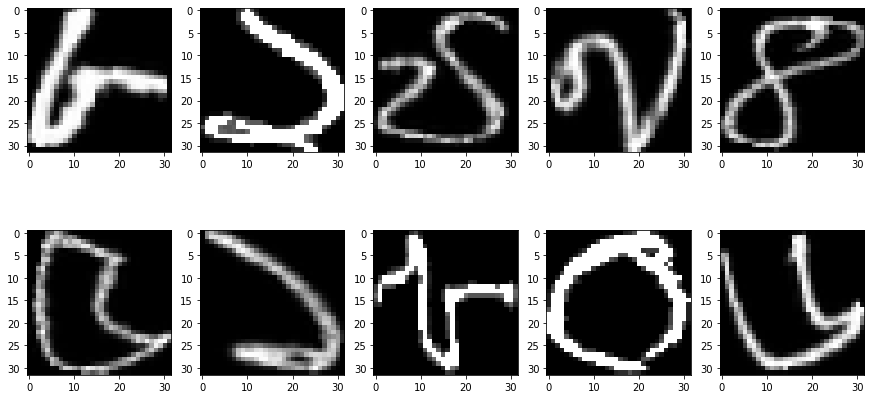

Labels : [[8]
 [1]
 [9]
 [9]
 [4]]
Labels : [[5]
 [1]
 [8]
 [0]
 [6]]


In [4]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_train_[i], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_train_[i+6], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("Labels : {}".format(y_train[0:5]))
print("Labels : {}".format(y_train[6:11]))

In [5]:
# Normalizing the input
x_train_ = x_train_.astype('float32')
x_train_/=255

x_test_ = x_test_.astype('float32')
x_test_/=255

print(x_train_.shape)
print(x_test_.shape)

(54000, 32, 32)
(4000, 32, 32)


In [6]:
y_train_ = to_categorical(y_train, num_classes=10, dtype='float32')
y_test_ = to_categorical(y_test, num_classes=10, dtype='float32')

print("Train Set Size = {} images".format(y_train.shape[0]))
print("Test Set Size = {} images".format(y_test.shape[0]))

Train Set Size = 54000 images
Test Set Size = 4000 images


In [7]:
# load model
from keras import models    
model_new = models.load_model('/content/drive/MyDrive/model/resnet_model.h5')
#set trainable false for pretrained model
for layer in model_new.layers[:-39]:
    layer.trainable = False

for l in model_new.layers:
    print(l.name, l.trainable)

input_1 False
zero_padding2d False
conv1 False
bn_conv1 False
activation False
max_pooling2d False
res2a_branch2a False
bn2a_branch2a False
activation_1 False
res2a_branch2b False
bn2a_branch2b False
activation_2 False
res2a_branch2c False
res2a_branch1 False
bn2a_branch2c False
bn2a_branch1 False
add False
activation_3 False
res2b_branch2a False
bn2b_branch2a False
activation_4 False
res2b_branch2b False
bn2b_branch2b False
activation_5 False
res2b_branch2c False
bn2b_branch2c False
add_1 False
activation_6 False
res2c_branch2a False
bn2c_branch2a False
activation_7 False
res2c_branch2b False
bn2c_branch2b False
activation_8 False
res2c_branch2c False
bn2c_branch2c False
add_2 False
activation_9 False
res3a_branch2a False
bn3a_branch2a False
activation_10 False
res3a_branch2b False
bn3a_branch2b False
activation_11 False
res3a_branch2c False
res3a_branch1 False
bn3a_branch2c False
bn3a_branch1 False
add_3 False
activation_12 False
res3b_branch2a True
bn3b_branch2a True
activation_13 T

In [8]:
model_new.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']                  
                                                                                           

In [9]:
optimizer = 'adam'
objective = 'categorical_crossentropy'

#extract layer weight
last_layer = model_new.get_layer('avg_pool')
last_output = last_layer.output

net = Dropout(rate=.2)(last_output)
net = Flatten()(net)
net = Dropout(rate=.5)(net)

net = Dense(2048, activation='relu', name='fc')(net)
net = Dropout(rate=.2)(net)
net = Dense(1024, activation='relu', name='fc2')(net)
net = Dropout(rate=.2)(net)

net = Dense(10, activation='softmax', name='predictions_utl')(net)

# Create model
model_n = Model(inputs = model_new.input, outputs = net, name='resnet_utl')
model_n.compile(optimizer=optimizer, loss=objective, metrics=['accuracy'])

model_n.summary()

Model: "resnet_utl"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']                  
                                                                                         

In [10]:
for l in model_n.layers:
    print(l.name, l.trainable)

input_1 False
zero_padding2d False
conv1 False
bn_conv1 False
activation False
max_pooling2d False
res2a_branch2a False
bn2a_branch2a False
activation_1 False
res2a_branch2b False
bn2a_branch2b False
activation_2 False
res2a_branch2c False
res2a_branch1 False
bn2a_branch2c False
bn2a_branch1 False
add False
activation_3 False
res2b_branch2a False
bn2b_branch2a False
activation_4 False
res2b_branch2b False
bn2b_branch2b False
activation_5 False
res2b_branch2c False
bn2b_branch2c False
add_1 False
activation_6 False
res2c_branch2a False
bn2c_branch2a False
activation_7 False
res2c_branch2b False
bn2c_branch2b False
activation_8 False
res2c_branch2c False
bn2c_branch2c False
add_2 False
activation_9 False
res3a_branch2a False
bn3a_branch2a False
activation_10 False
res3a_branch2b False
bn3a_branch2b False
activation_11 False
res3a_branch2c False
res3a_branch1 False
bn3a_branch2c False
bn3a_branch1 False
add_3 False
activation_12 False
res3b_branch2a True
bn3b_branch2a True
activation_13 T

In [11]:
nb_epoch = 100
batch_size = 64

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

ret = model_n.fit(x_train_.reshape((-1,32,32,1)), y_train_, 
                  epochs=nb_epoch, batch_size=batch_size, verbose=1,
                  #validation_split=0.3,
                  validation_data=(x_test_, y_test_),
                  callbacks=[es])

Epoch 1/100
844/844 [==============================] - 34s 33ms/step - loss: 0.2826 - accuracy: 0.9315 - val_loss: 0.0805 - val_accuracy: 0.9712
Epoch 2/100
844/844 [==============================] - 27s 32ms/step - loss: 0.0947 - accuracy: 0.9727 - val_loss: 0.0530 - val_accuracy: 0.9808
Epoch 3/100
844/844 [==============================] - 27s 32ms/step - loss: 0.0642 - accuracy: 0.9818 - val_loss: 0.0459 - val_accuracy: 0.9835
Epoch 4/100
844/844 [==============================] - 27s 32ms/step - loss: 0.0585 - accuracy: 0.9840 - val_loss: 0.0421 - val_accuracy: 0.9840
Epoch 5/100
844/844 [==============================] - 27s 32ms/step - loss: 0.0424 - accuracy: 0.9881 - val_loss: 0.0414 - val_accuracy: 0.9855
Epoch 6/100
844/844 [==============================] - 27s 32ms/step - loss: 0.0283 - accuracy: 0.9909 - val_loss: 0.0462 - val_accuracy: 0.9840
Epoch 7/100
844/844 [==============================] - 27s 32ms/step - loss: 0.0269 - accuracy: 0.9916 - val_loss: 0.0477 - val_ac

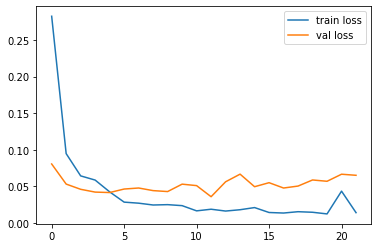

In [12]:
plt.plot(ret.history['loss'], label='train loss')
plt.plot(ret.history['val_loss'], label='val loss')
plt.legend()
plt.show()

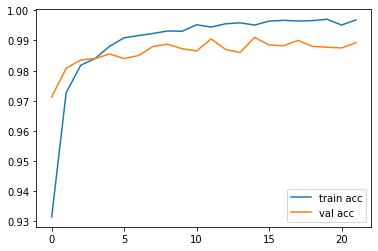

In [13]:
plt.plot(ret.history['accuracy'], label='train acc')
plt.plot(ret.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [14]:
# evaluate the model
_, train_acc = model_n.evaluate(x_train_, y_train_, verbose=0)
_, test_acc = model_n.evaluate(x_test_, y_test_, verbose=0)
print('Train accuracy: %.3f, Test accuracy: %.3f' % (train_acc, test_acc))

Train accuracy: 1.000, Test accuracy: 0.989


In [15]:
predictions = model_n.predict(x_test_.reshape((-1,32,32,1)), verbose=0)

In [16]:
def test_accuracy():
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err

In [17]:
p = test_accuracy()
print("Test accuracy: {} %".format(p[1]))

Test accuracy: 98.925 %


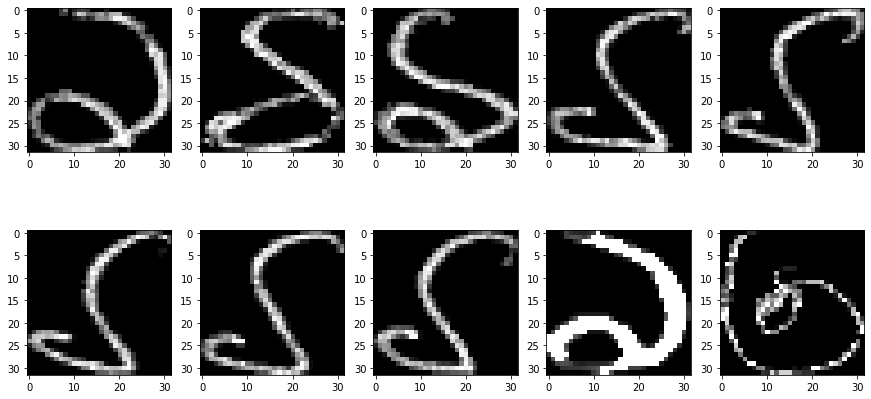

True:          [[1]
 [1]
 [1]
 [1]
 [1]]
classified as: [9 9 9 9 9]
True:          [[1]
 [1]
 [1]
 [1]
 [3]]
classified as: [6 9 9 9 8]


In [18]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_test_[p[2][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_test_[p[2][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(y_test[p[2][0:5]]))
print("classified as: {}".format(np.argmax(predictions[p[2][0:5]], axis=1)))

print("True:          {}".format(y_test[p[2][6:11]]))
print("classified as: {}".format(np.argmax(predictions[p[2][6:11]], axis=1)))